In [ ]:
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/store-sales-time-series-forecasting.zip' -d '/content/files'

Archive:  /content/drive/MyDrive/store-sales-time-series-forecasting.zip
  inflating: /content/files/holidays_events.csv  
  inflating: /content/files/oil.csv  
  inflating: /content/files/sample_submission.csv  
  inflating: /content/files/stores.csv  
  inflating: /content/files/test.csv  
  inflating: /content/files/train.csv  
  inflating: /content/files/transactions.csv  


In [ ]:
pip install lightgbm

In [ ]:
import tsfresh as tsf
import lightgbm as lgb

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xg

import matplotlib.pyplot as plt
import seaborn as sns


# EDA

Lets import data

In [ ]:
df = pd.read_csv('/content/files/train.csv', index_col = 'id', parse_dates=['date'])

Basically, we have 1782 time series for each goods family and each store. Best way to represent it is using groupby method from pandas and making multiindex columns

In [ ]:
y = df.groupby(['date', 'family', 'store_nbr'])['sales'].mean().unstack(['family', 'store_nbr'])
y.head(5)

family     AUTOMOTIVE                                                   ...  \
store_nbr          1    2     3     4    5    6    7     8     9    10  ...   
date                                                                    ...   
2013-01-01        0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...   
2013-01-02        2.0  8.0  10.0  12.0  6.0  3.0  8.0   7.0   5.0  3.0  ...   
2013-01-03        3.0  5.0   7.0   3.0  4.0  2.0  3.0   1.0  22.0  2.0  ...   
2013-01-04        3.0  3.0   3.0   7.0  6.0  4.0  3.0  12.0   0.0  2.0  ...   
2013-01-05        5.0  5.0  12.0   9.0  4.0  4.0  3.0  10.0  27.0  0.0  ...   

family         SEAFOOD                                                         \
store_nbr           45      46          47         48      49      50      51   
date                                                                            
2013-01-01    0.000000   0.000    0.000000   0.000000   0.000   0.000   0.000   
2013-01-02  105.544000  69.782  159.518000  37.161000  70.578  42.266  97.801   
2013-01-03   37.000000  48.214   85.157000  30.623000  57.354  26.147  64.062   
2013-01-04  126.444000  56.922  103.164000  28.664001  67.463  25.663  94.971   
2013-01-05  126.548004  68.260  104.160995  36.337000  43.377  32.327  75.149   

family                     
store_nbr    52   53   54  
date                       
2013-01-01  0.0  0.0  0.0  
2013-01-02  0.0  0.0  3.0  
2013-01-03  0.0  0.0  2.0  
2013-01-04  0.0  0.0  2.0  
2013-01-05  0.0  0.0  1.0  

[5 rows x 1782 columns]

Lets count average sales for each day

In [ ]:
average_sales = df.groupby(['date', 'family', 'store_nbr'])['sales'].mean()

average_sales = y.stack(['family', 'store_nbr']).groupby('date').mean().to_frame('sales')
average_sales["day_of_week"] = average_sales.index.dayofweek
average_sales["week"] = average_sales.index.isocalendar().week.astype('int')
average_sales["day_of_year"] = average_sales.index.dayofyear
average_sales["year"] = average_sales.index.year

average_sales.head()

,sales,day_of_week,week,day_of_year,year
date,,,,,
2013-01-01,1.409438,1,1,1,2013
2013-01-02,278.390807,2,1,2,2013
2013-01-03,202.840197,3,1,3,2013
2013-01-04,198.911154,4,1,4,2013
2013-01-05,267.873244,5,1,5,2013


And show seasonal plot on average sales:

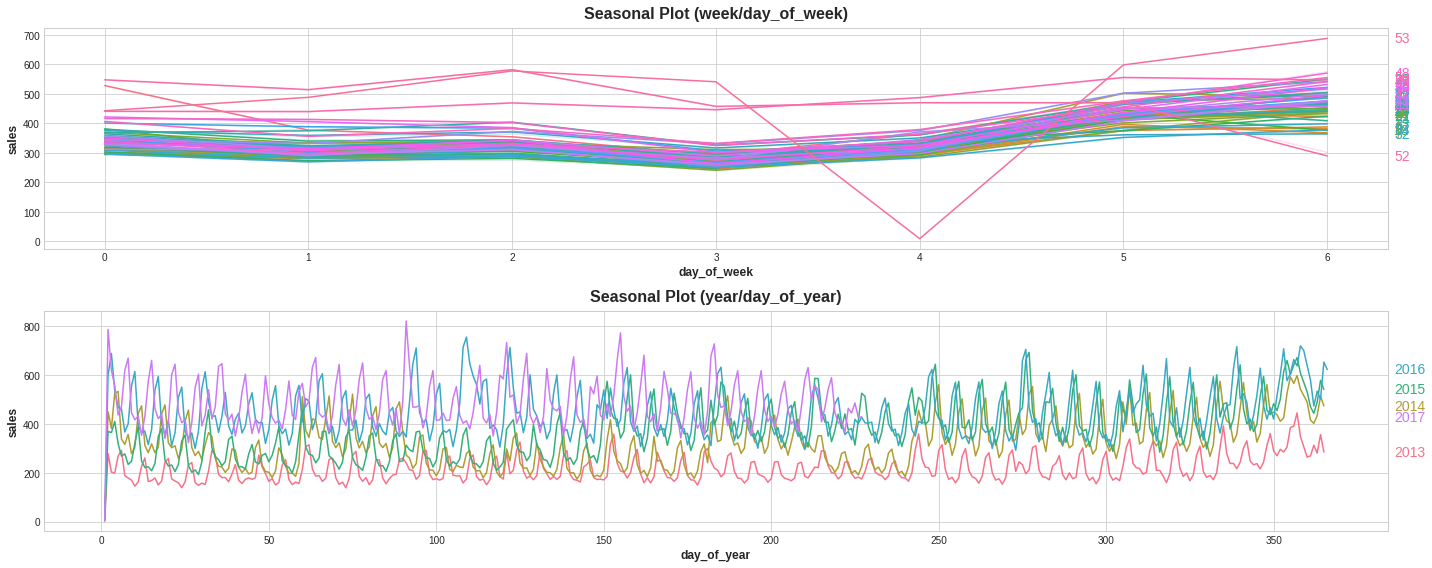

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
seasonal_plot(average_sales, y = "sales", period = "week", freq = "day_of_week", ax=ax0)
seasonal_plot(average_sales, y = "sales", period = "year", freq = "day_of_year", ax=ax1);

Periodogram (highes variance is for week period):

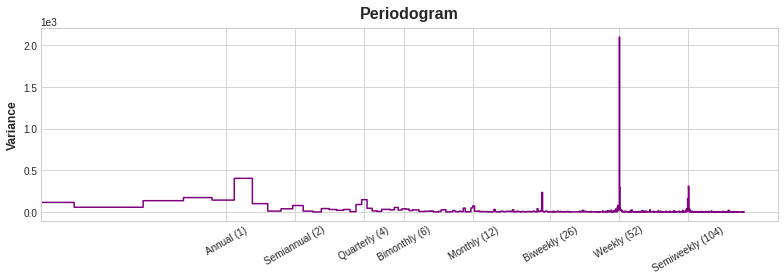

In [ ]:
plot_periodogram(average_sales.sales)

Another seasonal plot for week number

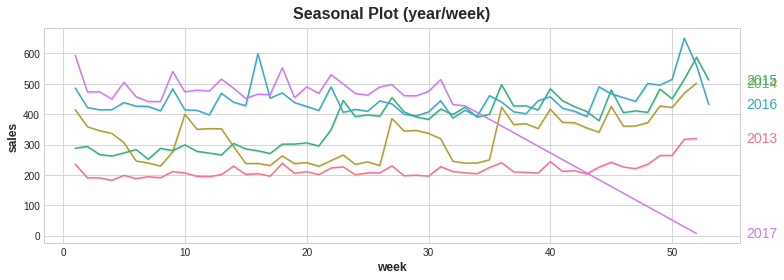

In [ ]:
seasonal_plot(average_sales, y = "sales", period = "year", freq = "week")

Lets check sales for AUTOMOTIVE family in store 3 in 2016 year

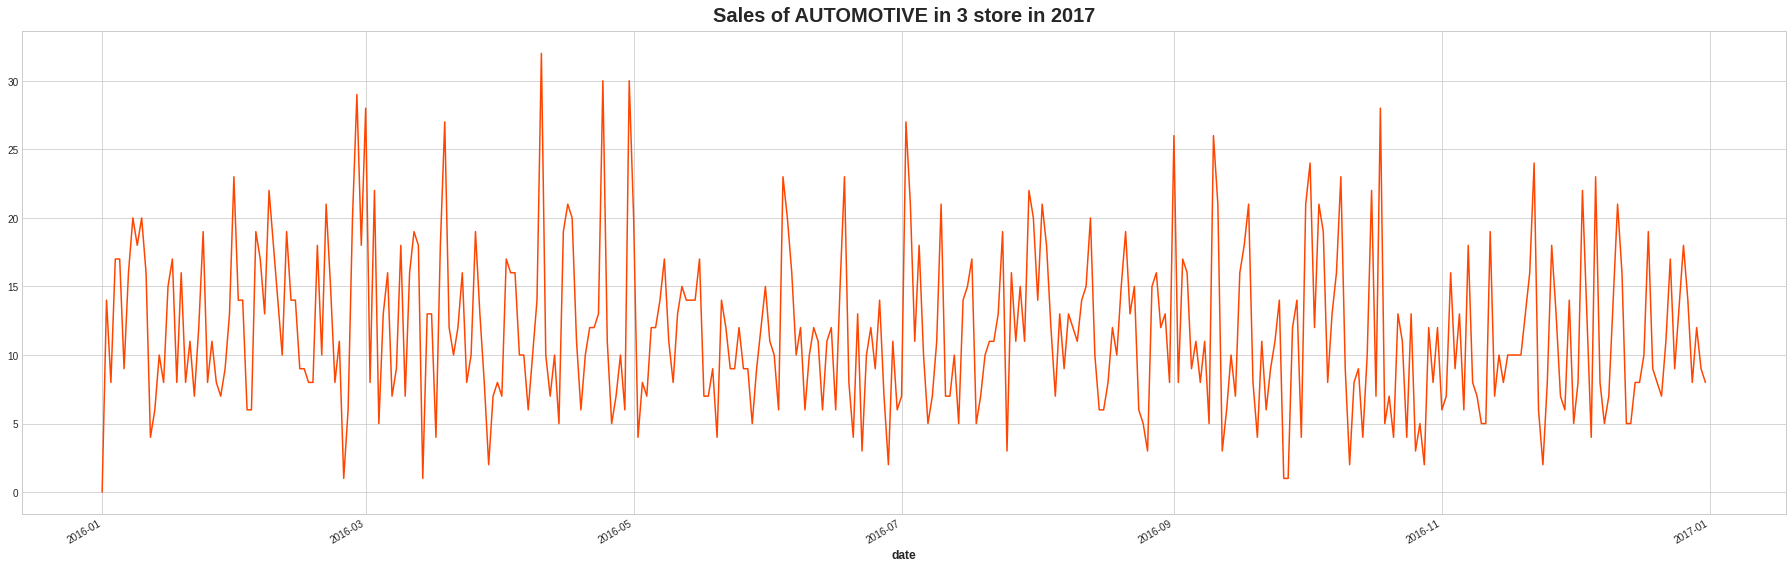

In [ ]:
df[(df.family == 'AUTOMOTIVE') & (df.store_nbr == 3)].set_index('date').sales.loc['2016'].plot(figsize = (25, 8), c='orangered')
plt.title(f'Sales of AUTOMOTIVE in {3} store in 2017', size = 20)
plt.show()

# Average sales prediction

Lets try simple linear regression on average sales

In [ ]:
target_1 = average_sales.drop(columns=['day_of_week', 'week', 'year', 'day_of_year'])

In [ ]:
dp = DeterministicProcess(
    index = target_1.index,
    constant = True,
    order = 1,
    drop = True,
)

X = dp.in_sample()
X.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target_1)
lr_on_avg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = lr_on_avg.predict(X_train)
y_predict = lr_on_avg.predict(X_test)

In [ ]:
print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train) ** 0.5}')
print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test) ** 0.5}')

RMSLE on train = 0.304826867132071
RMSLE on validation = 0.37626937866421806


It seems like its not hard to predict average sales using even LinearRegression. Lets try cubic trend

In [ ]:
dp = DeterministicProcess(
    index = target_1.index,
    constant = True,
    order = 3, #Cubic
    drop = True,
)

X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target_1, shuffle=False, test_size=30)
lr_on_avg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = lr_on_avg.predict(X_train)
y_predict = lr_on_avg.predict(X_test)

In [ ]:
print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train) ** 0.5}')
print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test) ** 0.5}')

RMSLE on train = 0.324397354353913
RMSLE on validation = 0.15230230372235218


We got even better model quality

In [ ]:
y_fit = pd.DataFrame(
    lr_on_avg.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_predict = pd.DataFrame(
    lr_on_avg.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

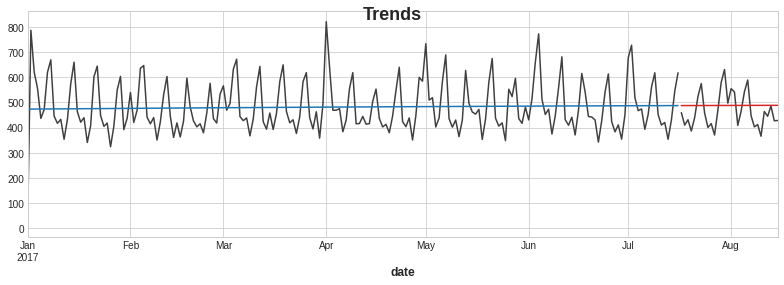

In [ ]:
axs = y_train.loc['2017'].plot(color='0.25', subplots=True, sharex=True, label='True')
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.loc['2017'].plot(color='C0', subplots=True, sharex=True, ax=axs, label='Fit')
axs = y_predict.plot(color='C3', subplots=True, sharex=True, ax=axs, label='Predict')

for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [ ]:
target_1 = target_1.asfreq('D')
fourier = CalendarFourier(freq = 'D', order = 26)

# const and trend features
dp = DeterministicProcess(
    index = target_1.index,
    constant = True,
    order = 3,
    seasonal = True,
    additional_terms = [fourier],
    drop = True,
)

X = dp.in_sample()
X.head()
target_1.fillna(method='bfill', inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target_1, shuffle=False, test_size=30)
lr_on_avg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = lr_on_avg.predict(X_train)
y_predict = lr_on_avg.predict(X_test)

In [ ]:
print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train) ** 0.5}')
print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test) ** 0.5}')

RMSLE on train = 0.27881191699887714
RMSLE on validation = 0.09913984412769143


In [ ]:
y_fit = pd.DataFrame(
    lr_on_avg.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_predict = pd.DataFrame(
    lr_on_avg.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

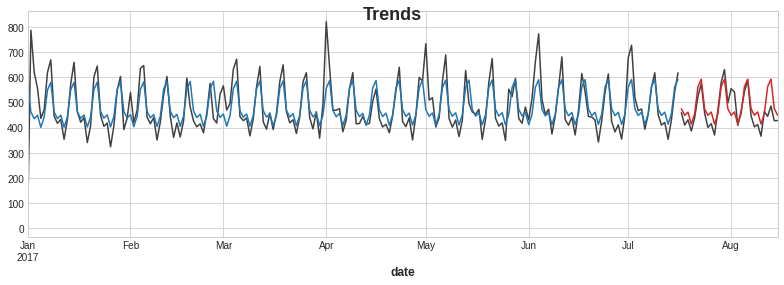

In [ ]:
axs = y_train.loc['2017'].plot(color='0.25', subplots=True, sharex=True, label='True')
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.loc['2017'].plot(color='C0', subplots=True, sharex=True, ax=axs, label='Fit')
axs = y_predict.plot(color='C3', subplots=True, sharex=True, ax=axs, label='Predict')

for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

Now it seems like almost perfect prediction, but lets not forget that we need to predict for each store and each family of goods

We handled average sales without using additional variables such as oild price and holidays.

# Multioutput regression

Ok, average sales prediction is simple task. Lets now try to predict for each family and each store

In [ ]:
y = df.groupby(['date', 'family', 'store_nbr'])['sales'].mean().unstack(['family', 'store_nbr'])
y.head(5)

family     AUTOMOTIVE                                                   ...  \
store_nbr          1    2     3     4    5    6    7     8     9    10  ...   
date                                                                    ...   
2013-01-01        0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...   
2013-01-02        2.0  8.0  10.0  12.0  6.0  3.0  8.0   7.0   5.0  3.0  ...   
2013-01-03        3.0  5.0   7.0   3.0  4.0  2.0  3.0   1.0  22.0  2.0  ...   
2013-01-04        3.0  3.0   3.0   7.0  6.0  4.0  3.0  12.0   0.0  2.0  ...   
2013-01-05        5.0  5.0  12.0   9.0  4.0  4.0  3.0  10.0  27.0  0.0  ...   

family         SEAFOOD                                                         \
store_nbr           45      46          47         48      49      50      51   
date                                                                            
2013-01-01    0.000000   0.000    0.000000   0.000000   0.000   0.000   0.000   
2013-01-02  105.544000  69.782  159.518000  37.161000  70.578  42.266  97.801   
2013-01-03   37.000000  48.214   85.157000  30.623000  57.354  26.147  64.062   
2013-01-04  126.444000  56.922  103.164000  28.664001  67.463  25.663  94.971   
2013-01-05  126.548004  68.260  104.160995  36.337000  43.377  32.327  75.149   

family                     
store_nbr    52   53   54  
date                       
2013-01-01  0.0  0.0  0.0  
2013-01-02  0.0  0.0  3.0  
2013-01-03  0.0  0.0  2.0  
2013-01-04  0.0  0.0  2.0  
2013-01-05  0.0  0.0  1.0  

[5 rows x 1782 columns]

In [ ]:
yy = y.reset_index().reset_index()
yy

family    index       date AUTOMOTIVE                                      \
store_nbr                           1     2     3     4     5     6     7   
0             0 2013-01-01        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1             1 2013-01-02        2.0   8.0  10.0  12.0   6.0   3.0   8.0   
2             2 2013-01-03        3.0   5.0   7.0   3.0   4.0   2.0   3.0   
3             3 2013-01-04        3.0   3.0   3.0   7.0   6.0   4.0   3.0   
4             4 2013-01-05        5.0   5.0  12.0   9.0   4.0   4.0   3.0   
...         ...        ...        ...   ...   ...   ...   ...   ...   ...   
1679       1679 2017-08-11        1.0  14.0  10.0   3.0  12.0   5.0   2.0   
1680       1680 2017-08-12        6.0   7.0   9.0   4.0   1.0   7.0  10.0   
1681       1681 2017-08-13        1.0   9.0  15.0   6.0  15.0  11.0   3.0   
1682       1682 2017-08-14        1.0   4.0   7.0   2.0   6.0  10.0   3.0   
1683       1683 2017-08-15        4.0   2.0  12.0   7.0   9.0   7.0   5.0   

family           ...     SEAFOOD                                            \
store_nbr     8  ...          45      46          47         48         49   
0           0.0  ...    0.000000   0.000    0.000000   0.000000   0.000000   
1           7.0  ...  105.544000  69.782  159.518000  37.161000  70.578000   
2           1.0  ...   37.000000  48.214   85.157000  30.623000  57.354000   
3          12.0  ...  126.444000  56.922  103.164000  28.664001  67.463000   
4          10.0  ...  126.548004  68.260  104.160995  36.337000  43.377000   
...         ...  ...         ...     ...         ...        ...        ...   
1679        3.0  ...  135.124000  49.924   92.123000  34.453000  99.916000   
1680        3.0  ...   92.479004  53.406   81.053000  32.198000  72.866000   
1681        2.0  ...   99.755000  59.898   73.879000  36.005000  78.171000   
1682        6.0  ...   79.414000  43.762   68.986000  20.321000  79.832000   
1683        4.0  ...   81.885000  48.217   65.720000  19.752000  56.842003   

family                                          
store_nbr         50      51      52   53   54  
0           0.000000   0.000   0.000  0.0  0.0  
1          42.266000  97.801   0.000  0.0  3.0  
2          26.147000  64.062   0.000  0.0  2.0  
3          25.663000  94.971   0.000  0.0  2.0  
4          32.327000  75.149   0.000  0.0  1.0  
...              ...     ...     ...  ...  ...  
1679       22.524000  74.934  23.000  8.0  0.0  
1680       15.801001  38.772   5.000  6.0  1.0  
1681       41.527000  39.965  12.000  9.0  2.0  
1682       12.242000  41.584   6.595  9.0  0.0  
1683       15.314000  52.876   7.000  5.0  3.0  

[1684 rows x 1784 columns]

In [ ]:
y_a1 = y.asfreq('D')
y_a1.fillnda(method='bfill', inplace=True)

fourier = CalendarFourier('M', order=25)

dp = DeterministicProcess(
    index = y_a1.index,
    constant = True,
    order = 1,
    drop = True,
    seasonal = True,
    additional_terms = [fourier]
)

X = dp.in_sample()
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"sin(21,freq=M)","cos(21,freq=M)","sin(22,freq=M)","cos(22,freq=M)","sin(23,freq=M)","cos(23,freq=M)","sin(24,freq=M)","cos(24,freq=M)","sin(25,freq=M)","cos(25,freq=M)"
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,-0.897805,-0.440394,-0.968077,-0.250653,-0.998717,-0.050649,-0.988468,0.151428,-0.937752,0.347305
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.790776,-0.612106,0.485302,-0.874347,0.101168,-0.994869,-0.299363,-0.954139,-0.651372,-0.758758
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.201299,0.979530,0.724793,0.688967,0.988468,0.151428,0.897805,-0.440394,0.485302,-0.874347
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,-0.968077,-0.250653,-0.848644,0.528964,-0.201299,0.979530,0.571268,0.820763,0.988468,0.151428


First try:
1. Trend of order 1 + number of week day + (sin(month day), cos(month day))
2. Multioutput Linear Regression using these features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_a1, shuffle=False, test_size=15)
lr_on_avg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = lr_on_avg.predict(X_train).clip(0.0)
y_predict = lr_on_avg.predict(X_test).clip(0.0)

In [ ]:
print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train) ** 0.5}')
print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test) ** 0.5}')

RMSLE on train = 0.49011595650282025
RMSLE on validation = 0.5573160673147038


Not bad result, but seems a bit overfitted

Next try:
1. Cubic trend + week day index + additional features such as oil price and holiday indicators
2. LR model

In [ ]:
df_oil = pd.read_csv('/content/files/oil.csv', parse_dates=['date'])

df_holidays = pd.read_csv('/content/files/holidays_events.csv', parse_dates=['date'])

In [ ]:
df_holidays = df_holidays.set_index('date')
df_holidays = df_holidays['locale']
holidays = ['Local', 'Regional', 'National'] # asc order
def select_holiday(x):
    return holidays[max([holidays.index(holiday) for holiday in x])]

df_holidays = df_holidays.groupby('date').apply(select_holiday)

df_oil.fillna(method='bfill', inplace=True)

In [ ]:
# Fourier features

# const and trend features
dp = DeterministicProcess(
    index = y_a1.index,
    constant = True,
    order = 3,
    seasonal = True,
    drop = True,
)

X = dp.in_sample()
X = X.merge(df_oil, how='left', on='date')
X.fillna(X.dcoilwtico.mean(), inplace=True) #method='bfill',
X = X.merge(df_holidays, how='left', on='date')
X['locale'].fillna('No', inplace=True)
X = X.set_index('date')
X = X.merge(pd.get_dummies(X.locale), how='inner', on='date').drop(columns=['locale'])
print(X.shape, y.shape)
X.head()

(227, 15) (227, 1782)


,const,trend,trend_squared,trend_cubed,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",dcoilwtico,Local,National,No,Regional
date,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,49.42142,0,1,0,0
2017-01-02,1.0,2.0,4.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,52.36000,0,1,0,0
2017-01-03,1.0,3.0,9.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,52.36000,0,0,1,0
2017-01-04,1.0,4.0,16.0,64.0,0.0,0.0,1.0,0.0,0.0,0.0,53.26000,0,0,1,0
2017-01-05,1.0,5.0,25.0,125.0,0.0,0.0,0.0,1.0,0.0,0.0,53.77000,0,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_a1, shuffle=False, test_size=15)
lr_on_avg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = lr_on_avg.predict(X_train).clip(0.0)
y_predict = lr_on_avg.predict(X_test).clip(0.0)

In [ ]:
print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train) ** 0.5}')
print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test) ** 0.5}')

RMSLE on train = 0.5244609673668628
RMSLE on validation = 0.5801179665769125


Almost the same result

In [ ]:
y_fit = pd.DataFrame(
    lr_on_avg.predict(X_train).clip(0.0),
    index=y_train.index,
)
y_pred = pd.DataFrame(
    lr_on_avg.predict(X_test).clip(0.0),
    index=y_test.index,
)

In [ ]:
y_resid = lr_on_avg.predict(X_train) - y_train
y_resid.head()

rf = RandomForestRegressor().fit(X_train, y_resid)
y_resid_pred = rf.predict(X_test)

y_predict += y_resid_pred

print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test) ** 0.5}')

RMSLE on validation = 0.5801179665769125


Still not enough. Lets fit only on data of year 2017. Also now we will use new popular kaggle idea: train linear model on time series. Get residuals after training: y_resid = y_true - y_predicted. After getting residuals on train data we will use nonlinear model (Here its random forest) to fit on residuals. So our final predict will be result of two models predictions sum

In [ ]:
y_2017 = y.loc['2017']

In [ ]:
# Fourier features
fourier = CalendarFourier(freq = 'M', order = 10)

# const and trend features
dp = DeterministicProcess(
    index = y_2017.index,
    constant = True,
    order = 3,
    seasonal = True,
    #additional_terms = [fourier],
    drop = True,
)

X = dp.in_sample()
X = X.merge(df_oil, how='left', on='date')
X.fillna(method='bfill', inplace=True)
X = X.merge(df_holidays, how='left', on='date')
X['locale'].fillna('No', inplace=True)
X = X.set_index('date')
X = X.merge(pd.get_dummies(X.locale), how='inner', on='date').drop(columns=['locale'])
print(X.shape, y.shape)
X.head()

(227, 15) (227, 1782)


,const,trend,trend_squared,trend_cubed,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",dcoilwtico,Local,National,No,Regional
date,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,52.36,0,1,0,0
2017-01-02,1.0,2.0,4.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,52.36,0,1,0,0
2017-01-03,1.0,3.0,9.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,52.36,0,0,1,0
2017-01-04,1.0,4.0,16.0,64.0,0.0,0.0,1.0,0.0,0.0,0.0,53.26,0,0,1,0
2017-01-05,1.0,5.0,25.0,125.0,0.0,0.0,0.0,1.0,0.0,0.0,53.77,0,0,1,0


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_2017, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index).clip(0.0)

In [ ]:
y_fit = pd.DataFrame(
    model.predict(X_train).clip(0.0),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_valid).clip(0.0),
    index=y_valid.index,
    columns=y_valid.columns,
)

In [ ]:
y_resid = (y_train - y_fit)
y_resid.head()

family        AUTOMOTIVE                                            \
store_nbr             1             2             3             4    
date                                                                 
2017-01-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2017-01-02 -3.642242e-11 -2.607958e-11 -4.097167e-11 -3.644907e-11   
2017-01-03  1.356293e-11  1.027090e-11  1.636735e-11  1.933920e-11   
2017-01-04  9.903189e-12  1.124434e-11  1.783107e-11  1.368683e-11   
2017-01-05 -8.771650e-12 -3.982592e-12 -7.689849e-12 -7.712941e-12   

family                                                              \
store_nbr             5             6             7             8    
date                                                                 
2017-01-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2017-01-02 -3.246647e-11 -4.127010e-11 -4.169998e-11 -3.887912e-11   
2017-01-03  9.705126e-12  1.754330e-11  2.301803e-11  1.609024e-11   
2017-01-04  0.000000e+00  1.461231e-11  1.419487e-11  1.502798e-11   
2017-01-05 -7.221779e-12 -8.537171e-12 -8.974155e-12 -6.711076e-12   

family                                  ...       SEAFOOD                \
store_nbr             9             10  ...            45            46   
date                                    ...                               
2017-01-01  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
2017-01-02 -2.768807e-11 -1.349854e-11  ... -7.732694e-10 -2.757972e-10   
2017-01-03  1.148237e-11  6.988188e-12  ...  3.719975e-10  1.144542e-10   
2017-01-04  9.480416e-12  4.948930e-12  ...  2.922320e-10  1.166427e-10   
2017-01-05 -1.028955e-11 -3.122835e-12  ... -1.965077e-10 -6.356515e-11   

family                                                              \
store_nbr             47            48            49            50   
date                                                                 
2017-01-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2017-01-02 -5.857430e-10 -1.113563e-10 -5.904894e-10 -2.064411e-10   
2017-01-03  2.399503e-10  2.616751e-11  2.357865e-10  9.789147e-11   
2017-01-04  2.278853e-10  4.411760e-11  2.154721e-10  7.153744e-11   
2017-01-05 -1.573426e-10 -3.247536e-11 -1.439417e-10 -3.412026e-11   

family                                                              
store_nbr             51            52            53            54  
date                                                                
2017-01-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
2017-01-02 -2.552270e-10 -3.291243e-13 -4.386536e-11 -2.794387e-11  
2017-01-03  1.147669e-10  0.000000e+00  1.659117e-11  1.514167e-11  
2017-01-04  9.413981e-11  0.000000e+00  1.642597e-11  1.096723e-11  
2017-01-05 -7.475620e-11  0.000000e+00 -1.269029e-11 -4.250822e-12  

[5 rows x 1782 columns]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X_train, y_resid)


In [ ]:
y_resid_pred = pd.DataFrame(
    rf.predict(X_valid),
    index=y_valid.index,
    columns=y_valid.columns,
)

In [ ]:
y_p = y_pred + y_resid_pred

Lets get average of predicts through products and stores and compare with actual averages graphs

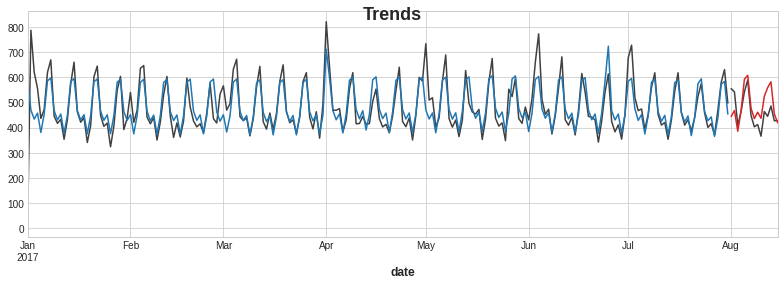

In [ ]:
axs = y_train.mean(axis=1).loc['2017'].plot(color='0.25', subplots=True, sharex=True, label='True')
axs = y_valid.mean(axis=1).plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.mean(axis=1).loc['2017'].plot(color='C0', subplots=True, sharex=True, ax=axs, label='Fit')
axs = y_p.mean(axis=1).plot(color='C3', subplots=True, sharex=True, ax=axs, label='Predict')
plt.legend()
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

Average sales predict is still almost perfect
Lets check predicts for random family and random store

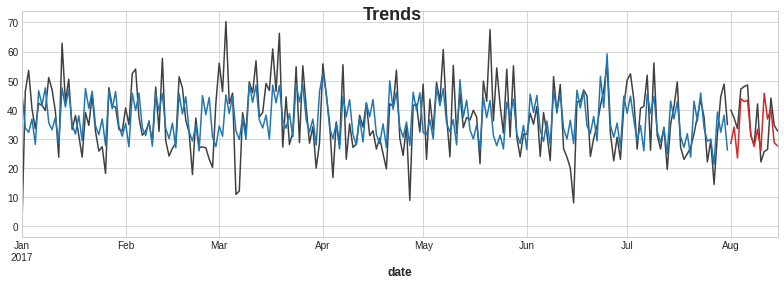

In [ ]:
axs = y_train['SEAFOOD'][2].loc['2017'].plot(color='0.25', subplots=True, sharex=True, label='True')
axs = y_valid['SEAFOOD'][2].plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit['SEAFOOD'][2].loc['2017'].plot(color='C0', subplots=True, sharex=True, ax=axs, label='Fit')
axs = y_p['SEAFOOD'][2].plot(color='C3', subplots=True, sharex=True, ax=axs, label='Predict')
plt.legend()
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

Now it doesnt seem that good. At this point PUBLIC SCORE = 0.67 (Top 1 is 0.37)

Lets try last approach. Here we will generate features using TSfresh library.

After generation we will concatenate with additional features such as oil price and holidays indicator and fit gradient boosting model on each time series (1800 of them)

# Final approach

In [ ]:
# Fourier features
y_final = y.copy()
y_final = y_final.asfreq('D')
y_final.fillna(method='bfill', inplace=True)

# const and trend features
dp = DeterministicProcess(
    index = y_final.index,
    constant = True,
    order = 1,
    seasonal = True,
    drop = True,
)

X = pd.concat([dp.in_sample(), dp.out_of_sample(steps=16)], axis=0).rename_axis('date')
XX = X.reset_index().reset_index()
ex_f = tsf.extract_features(XX, column_id='index', column_sort="date")
tsf.utilities.dataframe_functions.impute(ex_f)



Feature Extraction: 100%|██████████| 13632/13632 [06:32<00:00, 34.74it/s]


,const__variance_larger_than_standard_deviation,const__has_duplicate_max,const__has_duplicate_min,const__has_duplicate,const__sum_values,const__abs_energy,const__mean_abs_change,const__mean_change,const__mean_second_derivative_central,const__median,...,"s(7,7)__permutation_entropy__dimension_6__tau_1","s(7,7)__permutation_entropy__dimension_7__tau_1","s(7,7)__query_similarity_count__query_None__threshold_0.0","s(7,7)__matrix_profile__feature_""min""__threshold_0.98","s(7,7)__matrix_profile__feature_""max""__threshold_0.98","s(7,7)__matrix_profile__feature_""mean""__threshold_0.98","s(7,7)__matrix_profile__feature_""median""__threshold_0.98","s(7,7)__matrix_profile__feature_""25""__threshold_0.98","s(7,7)__matrix_profile__feature_""75""__threshold_0.98","s(7,7)__mean_n_absolute_max__number_of_maxima_7"
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1700,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1701,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1702,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets delete constant features

In [ ]:
m2 = (ex_f != 0).any()
a = m2.index[m2]
ex_f = ex_f[a]
m3 = (ex_f != 1).any()
a2 = m3.index[m3]

ex_f = ex_f[a2]

In [ ]:
X = pd.concat([dp.in_sample(), dp.out_of_sample(steps=16)], axis=0).rename_axis('date')

In [ ]:
X = X.merge(df_oil, how='left', on='date')
X.fillna(X['dcoilwtico'].mean(), inplace=True) #method='bfill',
X = X.merge(df_holidays, how='left', on='date')
X['locale'].fillna('No', inplace=True)
X = X.set_index('date')
X = X.merge(pd.get_dummies(X.locale), how='inner', on='date').drop(columns=['locale'])
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",dcoilwtico,Local,National,No,Regional
date,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,93.140000,0,1,0,0
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,93.140000,0,0,1,0
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,92.970000,0,0,1,0
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,93.120000,0,0,1,0
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,67.673325,0,1,0,0


In [ ]:
ex_f[['dcoilwtico',	'Local',	'National',	'No',	'Regional']] =  X[['dcoilwtico',	'Local',	'National',	'No',	'Regional']].reset_index().drop(columns='date')
ex_f.head()

,const__benford_correlation,"const__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","const__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","const__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","const__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",trend__sum_values,trend__abs_energy,trend__median,trend__mean,trend__root_mean_square,...,"s(7,7)__fft_coefficient__attr_""abs""__coeff_0","s(7,7)__value_count__value_0","s(7,7)__value_count__value_1","s(7,7)__range_count__max_1__min_-1","s(7,7)__count_below__t_0",dcoilwtico,Local,National,No,Regional
0,0.864123,0.613291,0.38788,0.274272,0.19394,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,93.140000,0,1,0,0
1,0.864123,0.613291,0.38788,0.274272,0.19394,2.0,4.0,2.0,2.0,2.0,...,0.0,1.0,0.0,1.0,1.0,93.140000,0,0,1,0
2,0.864123,0.613291,0.38788,0.274272,0.19394,3.0,9.0,3.0,3.0,3.0,...,0.0,1.0,0.0,1.0,1.0,92.970000,0,0,1,0
3,0.864123,0.613291,0.38788,0.274272,0.19394,4.0,16.0,4.0,4.0,4.0,...,0.0,1.0,0.0,1.0,1.0,93.120000,0,0,1,0
4,0.864123,0.613291,0.38788,0.274272,0.19394,5.0,25.0,5.0,5.0,5.0,...,0.0,1.0,0.0,1.0,1.0,67.673325,0,1,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ex_f[:-16], y_final['AUTOMOTIVE'][1], shuffle=False, test_size=15)
lr_on_avg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = lr_on_avg.predict(X_train).clip(0.0)
y_predict = lr_on_avg.predict(X_test).clip(0.0)

print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train) ** 0.5}')
print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test) ** 0.5}')

RMSLE on train = 0.6316461304347754
RMSLE on validation = 0.5204123016236931


Lets try Gradient Boosting

In [ ]:
%%time

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

params = {
      'task': ['predict'],
      'boosting': ['gbdt'],
      'objective': ['regression'],
      'num_iterations': [  1500, 2000  ],
      'learning_rate':[  0.05, 0.005 ],
      'num_leaves':[ 7, 15  ],
      'max_depth' :[ 10,20],
      'reg_lambda': [0.75, 1]
}

tsp = TimeSeriesSplit(max_train_size=1500, n_splits=3)

clf = GridSearchCV(lgb.LGBMRegressor(random_state=0), params, cv=tsp.split(ex_f[:-16]), scoring='neg_mean_squared_log_error')
clf.fit(np.array(ex_f[:-16]), np.array(target_1))

CPU times: user 7min 47s, sys: 6.77 s, total: 7min 53s
Wall time: 4min 4s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7ff4a51bdf20>,
             estimator=LGBMRegressor(random_state=0),
             param_grid={'boosting': ['gbdt'], 'learning_rate': [0.05, 0.005],
                         'max_depth': [10, 20], 'num_iterations': [1500, 2000],
                         'num_leaves': [7, 15], 'objective': ['regression'],
                         'reg_lambda': [0.75, 1], 'task': ['predict']},
             scoring='neg_mean_squared_log_error')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ex_f[:-16], y_final['SEAFOOD'][2], shuffle=False, test_size=15)


params = clf.best_estimator_

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

model = clf.best_estimator_

y_pred = model.predict(X_test).clip(0.0)
y_fit = model.predict(X_train).clip(0.0)

print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train) ** 0.5}')
print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test) ** 0.5}')

RMSLE on train = 2.4194968262547003
RMSLE on validation = 2.0066199008143055


So we grid searched parameters on average sales and checked result for random family and store number. its not that high, but we can tune parameters for each of 1750+ series and the best approach is to find best parameters on average sales

In [ ]:
df_sub = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(ex_f[:-16], y_a1, shuffle=False, test_size=15)


params = {'boosting': 'gbdt',
 'learning_rate': 0.005,
 'max_depth': 10,
 'num_iterations': 1000,
 'num_leaves': 7,
 'objective': 'regression',
 'reg_lambda': 1,
 'task': 'train',
 'verbose': -1}

for column in y.columns:
  lgb_train = lgb.Dataset(X_train, y_train[column])
  lgb_eval = lgb.Dataset(X_test, y_test[column], reference=lgb_train)
  model = lgb.train(params,
                  train_set=lgb_train,
                  valid_sets=lgb_eval,
                  verbose_eval=False,
  )
  y_pred = model.predict(X_test).clip(0.0)
  y_fit = model.predict(X_train).clip(0.0)
  print(f'COLUMN: {column}')
  print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train[column]) ** 0.5}')
  print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test[column]) ** 0.5}')
  print()

  df_sub[column] = model.predict(ex_f[-16:])

Выходные данные были обрезаны до нескольких последних строк (5000).
COLUMN: ('DELI', 47)
RMSLE on train = 0.38682825469151527
RMSLE on validation = 4.879112191131833

COLUMN: ('DELI', 48)
RMSLE on train = 0.4014545969912251
RMSLE on validation = 4.886096808894566

COLUMN: ('DELI', 49)
RMSLE on train = 0.3539162350373473
RMSLE on validation = 4.4887108742802955

COLUMN: ('DELI', 50)
RMSLE on train = 0.372096151560973
RMSLE on validation = 4.55217869414755

COLUMN: ('DELI', 51)
RMSLE on train = 0.33876464839633424
RMSLE on validation = 3.9408557681675176

COLUMN: ('DELI', 52)
RMSLE on train = 0.3594068120633763
RMSLE on validation = 4.303208033641931

COLUMN: ('DELI', 53)
RMSLE on train = 0.7264657139521673
RMSLE on validation = 3.797202784233018

COLUMN: ('DELI', 54)
RMSLE on train = 0.3397211304060347
RMSLE on validation = 3.8347928469119483

COLUMN: ('EGGS', 1)
RMSLE on train = 0.32406029067504005
RMSLE on validation = 3.180678397764676

COLUMN: ('EGGS', 2)
RMSLE on train = 0.31144822

PUBLIC SCORE = 0.51 at this point. Much better than previuos but still not that good. (Most popular code notebook has 0.57 score)

## Sumbition script

In [ ]:
dft = pd.read_csv('files/test.csv').groupby(['date', 'family', 'store_nbr'])['onpromotion'].mean().unstack(['family', 'store_nbr'])
dft.head(5)

family     AUTOMOTIVE                                               ...  \
store_nbr          1    2    3    4    5    6    7    8    9    10  ...   
date                                                                ...   
2017-08-16        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2017-08-17        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2017-08-18        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2017-08-19        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2017-08-20        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

family     SEAFOOD                                               
store_nbr       45   46   47   48   49   50   51   52   53   54  
date                                                             
2017-08-16     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-17     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-18     7.0  6.0  6.0  6.0  7.0  4.0  6.0  3.0  1.0  0.0  
2017-08-19     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2017-08-20     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 1782 columns]

In [ ]:
df_sub = df_sub.set_index(dp.out_of_sample(steps = 16).rename_axis('date').reset_index()['date'])

In [ ]:
test = df_sub.copy()
test.head(3)

,"(AUTOMOTIVE, 1)","(AUTOMOTIVE, 2)","(AUTOMOTIVE, 3)","(AUTOMOTIVE, 4)","(AUTOMOTIVE, 5)","(AUTOMOTIVE, 6)","(AUTOMOTIVE, 7)","(AUTOMOTIVE, 8)","(AUTOMOTIVE, 9)","(AUTOMOTIVE, 10)",...,"(SEAFOOD, 45)","(SEAFOOD, 46)","(SEAFOOD, 47)","(SEAFOOD, 48)","(SEAFOOD, 49)","(SEAFOOD, 50)","(SEAFOOD, 51)","(SEAFOOD, 52)","(SEAFOOD, 53)","(SEAFOOD, 54)"
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,5.160273,5.539457,9.996104,2.403815,5.167872,4.355973,5.871663,5.481336,10.730562,0.982162,...,78.838560,36.950260,60.012796,17.278532,74.737404,17.660182,45.712819,8.187929,3.532974,3.141226
2017-08-17,4.830741,5.757405,9.007657,2.441120,5.385420,4.201605,5.696038,4.606316,10.710629,0.969120,...,61.372200,34.400175,55.152188,17.765952,62.580865,16.522848,38.087579,8.400966,3.398576,2.923892
2017-08-18,6.451596,5.789458,9.684246,2.815958,5.123267,4.018152,6.023215,5.391360,9.528496,1.138593,...,124.196063,53.818252,90.081890,27.422815,115.891561,23.533634,73.502026,9.247182,6.013337,1.969056


In [ ]:
index = pd.MultiIndex.from_tuples(df_sub, names=["family", "store_nbr"])
test.columns = index

In [ ]:
test.head(3)

family     AUTOMOTIVE                                                    \
store_nbr          1         2         3         4         5         6    
date                                                                      
2017-08-16   5.160273  5.539457  9.996104  2.403815  5.167872  4.355973   
2017-08-17   4.830741  5.757405  9.007657  2.441120  5.385420  4.201605   
2017-08-18   6.451596  5.789458  9.684246  2.815958  5.123267  4.018152   

family                                               ...     SEAFOOD  \
store_nbr         7         8          9         10  ...          45   
date                                                 ...               
2017-08-16  5.871663  5.481336  10.730562  0.982162  ...   78.838560   
2017-08-17  5.696038  4.606316  10.710629  0.969120  ...   61.372200   
2017-08-18  6.023215  5.391360   9.528496  1.138593  ...  124.196063   

family                                                                         \
store_nbr          46         47         48          49         50         51   
date                                                                            
2017-08-16  36.950260  60.012796  17.278532   74.737404  17.660182  45.712819   
2017-08-17  34.400175  55.152188  17.765952   62.580865  16.522848  38.087579   
2017-08-18  53.818252  90.081890  27.422815  115.891561  23.533634  73.502026   

family                                    
store_nbr         52        53        54  
date                                      
2017-08-16  8.187929  3.532974  3.141226  
2017-08-17  8.400966  3.398576  2.923892  
2017-08-18  9.247182  6.013337  1.969056  

[3 rows x 1782 columns]

In [ ]:
dft[dft.columns] = test[dft.columns]

In [ ]:
tst = test.stack(['family', 'store_nbr']).to_frame('sales').reset_index()

In [ ]:
import lightgbm as lgb

In [ ]:
dft = pd.read_csv('files/test.csv', parse_dates=['date'])
test_df = dft.reset_index().merge(tst, how = 'left', on = ['date', 'family', 'store_nbr'])
print(test_df.head())
test_df.loc[:, ['id', 'sales']].to_csv('sub.csv', index = False)

   index       id       date  store_nbr      family  onpromotion        sales
0      0  3000888 2017-08-16          1  AUTOMOTIVE            0     5.160273
1      1  3000889 2017-08-16          1   BABY CARE            0     0.000000
2      2  3000890 2017-08-16          1      BEAUTY            2     3.708747
3      3  3000891 2017-08-16          1   BEVERAGES           20  2448.510698
4      4  3000892 2017-08-16          1       BOOKS            0     0.442992


## Again, lets now try linear regression model for prediction and boosting model for residuals prediction

In [ ]:
df_sub = pd.DataFrame()




params = {'boosting': 'gbdt',
 'learning_rate': 0.005,
 'max_depth': 10,
 'num_iterations': 1000,
 'num_leaves': 7,
 'objective': 'regression',
 'reg_lambda': 1,
 'task': 'train',
 'verbose': -1}

for column in y.columns:

  #X_selected = tsf.select_features(ex_f[:-16].set_index(y_final.index), y_final[column])

  X_train, X_test, y_train, y_test = train_test_split(X_selected, y_final, shuffle=False, test_size=15)

  reg = Lasso(fit_intercept=False).fit(X_train, y_train[column])

  y_fit = reg.predict(X_train)

  y_resid_fit = y_train[column] - y_fit

  y_resid_val = y_test[column] - reg.predict(X_test)

  lgb_train = lgb.Dataset(X_train, y_resid_fit)
  lgb_eval = lgb.Dataset(X_test, y_resid_val, reference=lgb_train)
  model = lgb.train(params,
                  train_set=lgb_train,
                  valid_sets=lgb_eval,
                  verbose_eval=False,
  )

  y_pred = (model.predict(X_test) + reg.predict(X_test)).clip(0)
  y_fit = (model.predict(X_train) + reg.predict(X_train)).clip(0)

  print(f'COLUMN: {column}')
  print(f'RMSLE on train = {mean_squared_log_error(y_fit, y_train[column]) ** 0.5}')
  print(f'RMSLE on validation = {mean_squared_log_error(y_predict, y_test[column]) ** 0.5}')
  print()

  df_sub[column] = (model.predict(ex_f[X_selected.columns][-16:]) + reg.predict(ex_f[X_selected.columns][-16:])).clip(0.0)

COLUMN: ('AUTOMOTIVE', 1)
RMSLE on train = 0.6096300580340188
RMSLE on validation = 0.5204123016236931

COLUMN: ('AUTOMOTIVE', 2)
RMSLE on train = 0.5477224482103278
RMSLE on validation = 0.8110993137983564

COLUMN: ('AUTOMOTIVE', 3)
RMSLE on train = 0.46702104293965185
RMSLE on validation = 0.9537167743423675

COLUMN: ('AUTOMOTIVE', 4)
RMSLE on train = 0.5894785909596391
RMSLE on validation = 0.44462680250460607

COLUMN: ('AUTOMOTIVE', 5)
RMSLE on train = 0.4960663325195682
RMSLE on validation = 0.7523448255666232

COLUMN: ('AUTOMOTIVE', 6)
RMSLE on train = 0.5516959329593545
RMSLE on validation = 0.6933611444299569

COLUMN: ('AUTOMOTIVE', 7)
RMSLE on train = 0.6413891130784068
RMSLE on validation = 0.471219219096507

COLUMN: ('AUTOMOTIVE', 8)
RMSLE on train = 0.5944108441227571
RMSLE on validation = 0.5526305892138469

COLUMN: ('AUTOMOTIVE', 9)
RMSLE on train = 0.5887579996974168
RMSLE on validation = 1.1507415520600541

COLUMN: ('AUTOMOTIVE', 10)
RMSLE on train = 0.6637018140275789


KeyboardInterrupt: ignored

PUBLIC SCORE = 0.52, slightly worse than boosting

Now as we did chose two best approaches, lets use whole dataset without splitting into train and test

Lasso + LightGBM Boosting

In [ ]:
df_sub = pd.DataFrame()




params = {'boosting': 'gbdt',
 'learning_rate': 0.005,
 'max_depth': 10,
 'num_iterations': 1000,
 'num_leaves': 7,
 'objective': 'regression',
 'reg_lambda': 1,
 'task': 'train',
 'verbose': -1}

for column in y.columns:


  reg = Lasso(fit_intercept=False).fit(ex_f[:-16], y_final[column])

  y_fit = reg.predict(ex_f[:-16])

  y_resid_fit = y_final[column] - y_fit


  lgb_train = lgb.Dataset(ex_f[:-16], y_resid_fit)
  model = lgb.train(params,
                  train_set=lgb_train,
                  verbose_eval=False,
  )


  print(f'COLUMN: {column}')
  print()

  df_sub[column] = (model.predict(ex_f[-16:]) + reg.predict(ex_f[-16:])).clip(0.0)

COLUMN: ('AUTOMOTIVE', 1)

COLUMN: ('AUTOMOTIVE', 2)

COLUMN: ('AUTOMOTIVE', 3)

COLUMN: ('AUTOMOTIVE', 4)

COLUMN: ('AUTOMOTIVE', 5)

COLUMN: ('AUTOMOTIVE', 6)

COLUMN: ('AUTOMOTIVE', 7)

COLUMN: ('AUTOMOTIVE', 8)

COLUMN: ('AUTOMOTIVE', 9)

COLUMN: ('AUTOMOTIVE', 10)

COLUMN: ('AUTOMOTIVE', 11)

COLUMN: ('AUTOMOTIVE', 12)

COLUMN: ('AUTOMOTIVE', 13)

COLUMN: ('AUTOMOTIVE', 14)

COLUMN: ('AUTOMOTIVE', 15)

COLUMN: ('AUTOMOTIVE', 16)

COLUMN: ('AUTOMOTIVE', 17)

COLUMN: ('AUTOMOTIVE', 18)

COLUMN: ('AUTOMOTIVE', 19)

COLUMN: ('AUTOMOTIVE', 20)

COLUMN: ('AUTOMOTIVE', 21)

COLUMN: ('AUTOMOTIVE', 22)

COLUMN: ('AUTOMOTIVE', 23)

COLUMN: ('AUTOMOTIVE', 24)

COLUMN: ('AUTOMOTIVE', 25)

COLUMN: ('AUTOMOTIVE', 26)

COLUMN: ('AUTOMOTIVE', 27)

COLUMN: ('AUTOMOTIVE', 28)

COLUMN: ('AUTOMOTIVE', 29)

COLUMN: ('AUTOMOTIVE', 30)

COLUMN: ('AUTOMOTIVE', 31)

COLUMN: ('AUTOMOTIVE', 32)

COLUMN: ('AUTOMOTIVE', 33)

COLUMN: ('AUTOMOTIVE', 34)

COLUMN: ('AUTOMOTIVE', 35)

COLUMN: ('AUTOMOTIVE', 36)

C

Now Public score is 0.42. This result is much better. (Top 1 is 0.37)

Tuned LGBM Boosting:

In [ ]:
df_sub = pd.DataFrame()

params = {'boosting': 'gbdt',
 'learning_rate': 0.005,
 'max_depth': 10,
 'num_iterations': 1000,
 'num_leaves': 7,
 'objective': 'regression',
 'reg_lambda': 1,
 'task': 'train',
 'verbose': -1}

for column in y.columns:
  lgb_train = lgb.Dataset(ex_f[:-16], y_final[column])
  model = lgb.train(params,
                  train_set=lgb_train,
                  verbose_eval=False,
  )

  print(f'COLUMN: {column}')
  print()

  df_sub[column] = model.predict(ex_f[-16:])

COLUMN: ('AUTOMOTIVE', 1)

COLUMN: ('AUTOMOTIVE', 2)

COLUMN: ('AUTOMOTIVE', 3)

COLUMN: ('AUTOMOTIVE', 4)

COLUMN: ('AUTOMOTIVE', 5)

COLUMN: ('AUTOMOTIVE', 6)

COLUMN: ('AUTOMOTIVE', 7)

COLUMN: ('AUTOMOTIVE', 8)

COLUMN: ('AUTOMOTIVE', 9)

COLUMN: ('AUTOMOTIVE', 10)

COLUMN: ('AUTOMOTIVE', 11)

COLUMN: ('AUTOMOTIVE', 12)

COLUMN: ('AUTOMOTIVE', 13)

COLUMN: ('AUTOMOTIVE', 14)

COLUMN: ('AUTOMOTIVE', 15)

COLUMN: ('AUTOMOTIVE', 16)

COLUMN: ('AUTOMOTIVE', 17)

COLUMN: ('AUTOMOTIVE', 18)

COLUMN: ('AUTOMOTIVE', 19)

COLUMN: ('AUTOMOTIVE', 20)

COLUMN: ('AUTOMOTIVE', 21)

COLUMN: ('AUTOMOTIVE', 22)

COLUMN: ('AUTOMOTIVE', 23)

COLUMN: ('AUTOMOTIVE', 24)

COLUMN: ('AUTOMOTIVE', 25)

COLUMN: ('AUTOMOTIVE', 26)

COLUMN: ('AUTOMOTIVE', 27)

COLUMN: ('AUTOMOTIVE', 28)

COLUMN: ('AUTOMOTIVE', 29)

COLUMN: ('AUTOMOTIVE', 30)

COLUMN: ('AUTOMOTIVE', 31)

COLUMN: ('AUTOMOTIVE', 32)

COLUMN: ('AUTOMOTIVE', 33)

COLUMN: ('AUTOMOTIVE', 34)

COLUMN: ('AUTOMOTIVE', 35)

COLUMN: ('AUTOMOTIVE', 36)

C

PUBLIC SCORE = 0.41


So at this point best result is training 1750+ LightGMB Boosting models for each pair of (goods family, store) with using TSfresh feature generator, weekly seasonality and additional features (oil price, holidays).

Proposals for getting TOP 5 result:
1. Time series clusterization. Lets train concatenate data of similar series, it will give us bigger train data size and better accuracy of prediction.
2. Manual analysis of special good families. For some of them we can see much bigger error. Lets work with these series, add more features and try to get better results just for some of them.
3. Feature selection for each of 1750 series lets select features based on feature importance and provide random search of hyperparameters. For me its impossible because im using google collab for this problem solving and it can work only 12 strait hours, but this tusk can compile few days.
4. Models staking. We can do different Boosting models for data and stake them (You can see that top-1 result is staking because the result belongs to team, usually firs N kaggle competitors just stake their model and team up)  

## Another submition script

In [ ]:
dft = pd.read_csv('files/test.csv').groupby(['date', 'family', 'store_nbr'])['onpromotion'].mean().unstack(['family', 'store_nbr'])
dft.head(5)


family     AUTOMOTIVE                                               ...  \
store_nbr          1    2    3    4    5    6    7    8    9    10  ...   
date                                                                ...   
2017-08-16        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2017-08-17        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2017-08-18        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2017-08-19        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2017-08-20        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

family     SEAFOOD                                               
store_nbr       45   46   47   48   49   50   51   52   53   54  
date                                                             
2017-08-16     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-17     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-18     7.0  6.0  6.0  6.0  7.0  4.0  6.0  3.0  1.0  0.0  
2017-08-19     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2017-08-20     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 1782 columns]

In [ ]:
df_sub = df_sub.set_index(dp.out_of_sample(steps = 16).rename_axis('date').reset_index()['date'])

In [ ]:
test = df_sub.copy()
test.head(3)

,"(AUTOMOTIVE, 1)","(AUTOMOTIVE, 2)","(AUTOMOTIVE, 3)","(AUTOMOTIVE, 4)","(AUTOMOTIVE, 5)","(AUTOMOTIVE, 6)","(AUTOMOTIVE, 7)","(AUTOMOTIVE, 8)","(AUTOMOTIVE, 9)","(AUTOMOTIVE, 10)",...,"(SEAFOOD, 45)","(SEAFOOD, 46)","(SEAFOOD, 47)","(SEAFOOD, 48)","(SEAFOOD, 49)","(SEAFOOD, 50)","(SEAFOOD, 51)","(SEAFOOD, 52)","(SEAFOOD, 53)","(SEAFOOD, 54)"
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,4.971957,6.060839,10.104245,3.066696,5.802675,6.057276,5.522570,4.868344,11.486362,1.169845,...,77.398650,38.270315,61.166716,18.333997,75.325203,17.584884,46.075321,7.503748,3.653112,3.119046
2017-08-17,4.884561,6.169028,9.263716,3.016965,5.736366,5.859808,5.271927,4.141084,11.422115,1.142066,...,59.573653,35.765954,55.988693,18.358691,64.297064,16.288306,38.788232,7.686072,3.429174,2.770678
2017-08-18,6.172938,6.287579,10.129251,3.618941,5.802675,5.917272,5.663103,4.754369,10.553807,1.308862,...,124.855433,55.045222,89.997045,28.216124,115.240935,22.194248,75.791095,9.637026,5.833046,1.503458


In [ ]:
index = pd.MultiIndex.from_tuples(df_sub, names=["family", "store_nbr"])
test.columns = index

In [ ]:
dft[dft.columns] = test[dft.columns]

In [ ]:
tst = test.stack(['family', 'store_nbr']).to_frame('sales').reset_index()

In [ ]:
dft = pd.read_csv('files/test.csv', parse_dates=['date'])
test_df = dft.reset_index().merge(tst, how = 'left', on = ['date', 'family', 'store_nbr'])
print(test_df.head())
test_df.loc[:, ['id', 'sales']].to_csv('sub.csv', index = False)

   index       id       date  store_nbr      family  onpromotion        sales
0      0  3000888 2017-08-16          1  AUTOMOTIVE            0     4.971957
1      1  3000889 2017-08-16          1   BABY CARE            0     0.000000
2      2  3000890 2017-08-16          1      BEAUTY            2     3.641566
3      3  3000891 2017-08-16          1   BEVERAGES           20  2437.560923
4      4  3000892 2017-08-16          1       BOOKS            0     0.270394


In [ ]:
test_df['sales'] = test_df['sales'].clip(0)

# Implementing Boosting of Bidirectinal LSTM

In [ ]:
import pandas as pd
import numpy as np

from numpy import array
from keras.models import Sequential, clone_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

This algorithm is implementation of https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9438681 paper. There is no public implementation of boosting on lstm and especially on bidirect lstm, so i decided to implement it by myself for the project

In [ ]:
class RNNBoostingRegressor():

  def __init__(self, model, n_estimators, epochs=30):

    self.model = model
    self.epochs = epochs
    self.n_estimators = n_estimators
    self.models = [clone_model(self.model) for i in range(self.n_estimators)]
    self.epses = []

    for i in range(n_estimators):
      self.models[i].compile(optimizer='adam', loss='mse')


  def fit(self, X, y, verbose=0):

    preds = []
    self.models[0].fit(X, y, epochs=self.epochs, verbose=verbose)
    preds.append(self.models[0].predict(X).flatten())
    error = np.array(y) - self.models[0].predict(X).flatten()

    for i in range(1, self.n_estimators):


      self.models[i].fit(X, np.array(error), epochs=self.epochs, verbose=verbose)
      eps = self.get_params(a=0, b=1, T=10, s=1000, true=y, pred_p=preds[i-1], pred=self.models[i].predict(X).flatten())
      self.epses.append(eps)
      preds.append(preds[i-1] + eps*self.models[0].predict(X).flatten())
      error = np.array(y) - preds[-1]


  def predict_boosting(self, X, verbose=0):

    pred = self.models[0].predict(X, verbose=verbose)

    for i in range(1, self.n_estimators):
      pred += self.epses[i-1]*self.models[i].predict(X, verbose=verbose)

    return pred


  def get_params(self, a, b, s, T, true, pred_p, pred):
    an = a
    bn = b

    for t in range(T):

      Ot = np.arange(an, bn+s, (bn-an)/s)

      minimum = np.linalg.norm(true-(pred_p + Ot[0]*pred))
      for i in range(Ot.shape[0]):

        if np.linalg.norm(true-(pred_p + Ot[i]*pred)) <= minimum:

          minimum = Ot[i]
          min_ind = i

      anew = max(minimum - (bn-an)/s, 0)
      bnew = min(minimum + (bn-an)/s, 1)

      an, bn = anew, bnew

      return minimum



In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [ ]:
# Lets do function for right format of data
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

Lets make model and train

Lets check random family and random store

In [ ]:
data = y['DELI'][1]

IndexError: ignored

In [ ]:
test = data.tolist()[-15:]
data = data.tolist()[19:-15]

AttributeError: ignored

In [ ]:
%%time
n_steps = 30
X, y = split_sequence(data, n_steps)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

CPU times: user 9.38 ms, sys: 970 µs, total: 10.4 ms
Wall time: 16.3 ms


In [ ]:

lstm = Sequential()
lstm.add(Bidirectional(LSTM(100, activation='tanh'), input_shape=(n_steps, n_features)))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')

In [ ]:
L

(1620, 30, 1)

In [ ]:
model = RNNBoostingRegressor(lstm, n_estimators=5, epochs=100)

model.fit(X, y, verbose=True)

Epoch 1/100
51/51 [==============================] - 3s 7ms/step - loss: 15685.3232
Epoch 2/100
51/51 [==============================] - 0s 7ms/step - loss: 11867.7256
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 9249.7441
Epoch 4/100
51/51 [==============================] - 0s 6ms/step - loss: 7480.4136
Epoch 5/100
51/51 [==============================] - 0s 6ms/step - loss: 6089.5371
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 5011.7939
Epoch 7/100
51/51 [==============================] - 0s 6ms/step - loss: 4190.5435
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 3555.9143
Epoch 9/100
51/51 [==============================] - 0s 6ms/step - loss: 3066.3821
Epoch 10/100
51/51 [==============================] - 0s 7ms/step - loss: 2691.6704
Epoch 11/100
51/51 [==============================] - 0s 7ms/step - loss: 2406.5984
Epoch 12/100
51/51 [==============================] - 0s 6ms/step - loss: 2194.8596

(it was fitting almost 20 mins bacause i have no gpu more, collab limit)

Lets do rolling predict

In [ ]:
roll = 15
for i in range(roll):
  pred = model.predict_boosting(array(data[-30:]).reshape((1, n_steps, n_features)))
  data.append(max(0, pred.flatten()[0])) #.clip(0)

In [ ]:
data[-30:]

[176.483,
 164.567,
 158.587,
 127.906,
 143.225,
 143.608,
 45.012,
 157.249,
 150.592,
 135.268,
 116.137,
 178.409,
 122.68,
 54.296,
 189.11,
 123.627975,
 123.628296,
 123.62825,
 123.628296,
 123.628174,
 123.62828,
 123.62819,
 123.62782,
 123.628235,
 123.62813,
 123.628174,
 123.62816,
 123.628365,
 123.628174,
 123.627625]

In [ ]:
data[-15:]

[123.627975,
 123.628296,
 123.62825,
 123.628296,
 123.628174,
 123.62828,
 123.62819,
 123.62782,
 123.628235,
 123.62813,
 123.628174,
 123.62816,
 123.628365,
 123.628174,
 123.627625]

In [ ]:
print(f'RMSLE on validation {mean_squared_log_error(test, data[-15:]) ** 0.5}')

RMSLE on validation 0.37656154295326827


Compare with classic boosting result:
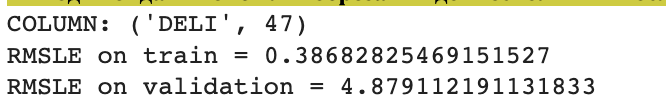

As you see its 24 times less, and i checked many different types of stores and families and my algorithm is always better. I would prove it but suddenly i dont have gpu time more and deadline is in 30 minuts

So basically i can assume, that this algorithm will help me to get top-15 in kaggle competition (and get golden medal!!) but suddenly i got no GPU and i use only google colab GPU. To fit 1800 series i need to spend around 50 hours of training time. Colab gives you only 12 hours a day, so  i will try to train and save result every day. Probably it will take 5 days to get done with fitting and submitting results

Also i will try to stake result of Classic Boosting, 2LSTM Boosting and Regression+Boosting to get even higher submission score. (Usual techique on kaggle)

In [ ]:
cols = ['GROCERY I', 'EGGS', 'DELI', 'LIQUOR,WINE,BEER']
colsfull = []

In [ ]:
for i in y.columns:
  if i[0] in cols:
    colsfull.append(i)

In [ ]:
data = y[colsfull[0]][4:]
X, y1 = split_sequence(data, n_steps)

In [ ]:
y1.shape

(1650,)

In [ ]:
data[-16:]

[36.58656,
 27.54318,
 30.866026,
 33.512707,
 20.52808,
 20.284128,
 23.629805,
 26.714338,
 29.900316,
 35.417843,
 41.44315,
 24.424269,
 21.139315,
 21.816628,
 22.955412,
 26.420855]

In [ ]:
df_sub[colsfull[-1]]

0     36.586559
1     27.543180
2     30.866026
3     33.512707
4     20.528080
5     20.284128
6     23.629805
7     26.714338
8     29.900316
9     35.417843
10    41.443150
11    24.424269
12    21.139315
13    21.816628
14    22.955412
15    26.420855
Name: (LIQUOR,WINE,BEER, 54), dtype: float32

In [ ]:
%%time

df_sub = pd.DataFrame()


for column in colsfull:

  data = y[column][4:].tolist()
  n_steps = 30
  X, y1 = split_sequence(data, n_steps)

  n_features = 1
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  model = RNNBoostingRegressor(lstm, n_estimators=3, epochs=50)

  model.fit(X, y1, verbose=0)

  roll = 16
  for i in range(roll):
    pred = model.predict_boosting(array(data[-30:]).reshape((1, n_steps, n_features)))
    data.append(max(0, pred.flatten()[0]))

  print(f'COLUMN: {column}')
  print()

  df_sub[column] = data[-16:]

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 1)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 2)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 3)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 4)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 5)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 6)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 7)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 8)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 9)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 10)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 11)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 12)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('DELI', 13)

52/52 [===========================

<timed exec>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


52/52 [==============================] - 0s 3ms/step
COLUMN: ('EGGS', 48)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('EGGS', 49)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('EGGS', 50)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('EGGS', 51)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('EGGS', 52)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('EGGS', 53)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('EGGS', 54)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('GROCERY I', 1)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('GROCERY I', 2)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('GROCERY I', 3)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('GROCERY I', 4)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('GROCERY I', 5)

52/52 [==============================] - 0s 3ms/step
COLUMN: ('GROCERY I', 6)

5